## Laboratory work 2
Variant: 3 (27) <br>
NN architecture: AlexNet <br>
SS learning method: Proxy Labelling <br>
Dataset: Cifar10 <br>
link to dataset: https://www.cs.toronto.edu/~kriz/cifar.html

## The CIFAR-10 dataset
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

### Imports

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torchmetrics
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [2]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Setting random number seed

In [10]:
# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(0)
# Set python seed
random.seed(0)
# Set numpy seed
np.random.seed(0)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False
# Configure PyTorch to use deterministic algorithms
# torch.use_deterministic_algorithms(True) (involves env. variables, so not used)
random_state_const = 0

In [16]:
# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(0)
g_test = torch.Generator().manual_seed(1)

### Data format

In [12]:
torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True)[0]

Files already downloaded and verified


(<PIL.Image.Image image mode=RGB size=32x32>, 6)

### Data read

This dataset already has train and test split (0.833 - 50000 to 0.167 - 10000). However, based on this article: https://github.com/P1Analytics/Pseudo-Label-for-Deep-Neural-Networks/blob/master/Pseudo-Label%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf <br>
the difference between training NN with and without Proxy labeling is best seen on small labeled datasets. For this work I'll take 480 labeled images (training set, labeled images, 30%), then we also need to take 480 * 7 / 3 = 1120 unlabeled images (training set, unlabeled images, 70%). For the test set we will take (480 + 1120) / 5 = 320 (original CIFAR 10 dataset ratio of train and test sets is 5:1, for test set we will also ensure stratification). Resulting split:
```
1. SGD + momentum                     - tr_full_set (training set, labeled images, 83.3%) +
                                        tst_set (test set, labeled images, 16.7%)
2. SGD + momentum + Proxy_Labelling   - tr_part_lbl_set (training set, labeled images, 25%) +
                                        tr_part_non_lbl_set (training set, unlabeled images, 58.3%) +
                                        tst_set (test set, labeled images, 16.7%)
Total images used for sets: 1920
```

In [13]:
total_image_count = 1920
tst_set_len = 320
tr_full_set_len = 1600
tr_part_lbl_set_len = 480
tr_part_non_lbl_set_len = 1120

In [9]:
# Calculate mean and std of test and train sets (255 - possible pixel value range)
traindata = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True).data / 255
testdata = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True).data / 255
mean_trn = traindata.mean(axis = (0,1,2)) 
std_trn = traindata.std(axis = (0,1,2))
mean_tst = testdata.mean(axis = (0,1,2)) 
std_tst = testdata.std(axis = (0,1,2))


# Create sequence of transformations: data -> resize to 256 x 256 -> 
#            -> (random horizontal flip for training data) -> tensor -> (tensor - mean) / std
transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean_trn, std_trn),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean_tst, std_tst),
])

# Number of images in each batch, recommended to == 2^n
batch_size = 32

# 10 classes used in CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# Download CIFAR10 trainset
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=transform_train)

# Create training set, labeled images, 83.3%
tr_full_set_fraction = tr_full_set_len / len(trainset)
tr_full_set, _ = torch.utils.data.random_split(trainset, [tr_full_set_fraction, 1 - tr_full_set_fraction], generator=g_train)
# Create training set, labeled images, 25% + training set, unlabeled images, 58.3% (their ratio is 3:7)
tr_part_lbl_set, tr_part_non_lbl_set = torch.utils.data.random_split(tr_full_set, [0.3, 0.7], generator=g_train)

# Create a sampler, that provides an iterable over the trainset
tr_full_loader = torch.utils.data.DataLoader(
    tr_full_set, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)
tr_part_lbl_loader = torch.utils.data.DataLoader(
    tr_part_lbl_set, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)

In [14]:
# Download CIFAR10 testset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=transform_test)

# Get sequence of labels in dataset
labels = [sample[1] for sample in testset]

# Calculate the number of splits needed
n_splits = len(testset) // tst_set_len

# Initialize StratifiedKFold with the calculated number of splits
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state_const)

# Initialize empty lists to store the indices for the new dataset
test_dataset_indices = []

# Perform the StratifiedKFold splits and keep adding indices until reaching the desired length
for test_indices, _ in stratified_kfold.split(np.zeros(len(labels)), labels):
    test_dataset_indices.extend(test_indices)
    if len(test_dataset_indices) >= tst_set_len:
        break

# Ensure that the new dataset length matches the desired length
test_dataset_indices = test_dataset_indices[:tst_set_len]

# Create a new dataset with the selected indices
tst_set = torch.utils.data.Subset(testset, test_dataset_indices)

# Create a sampler for testset
tst_set_loader = torch.utils.data.DataLoader(
    tst_set, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g_test)

### Data visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


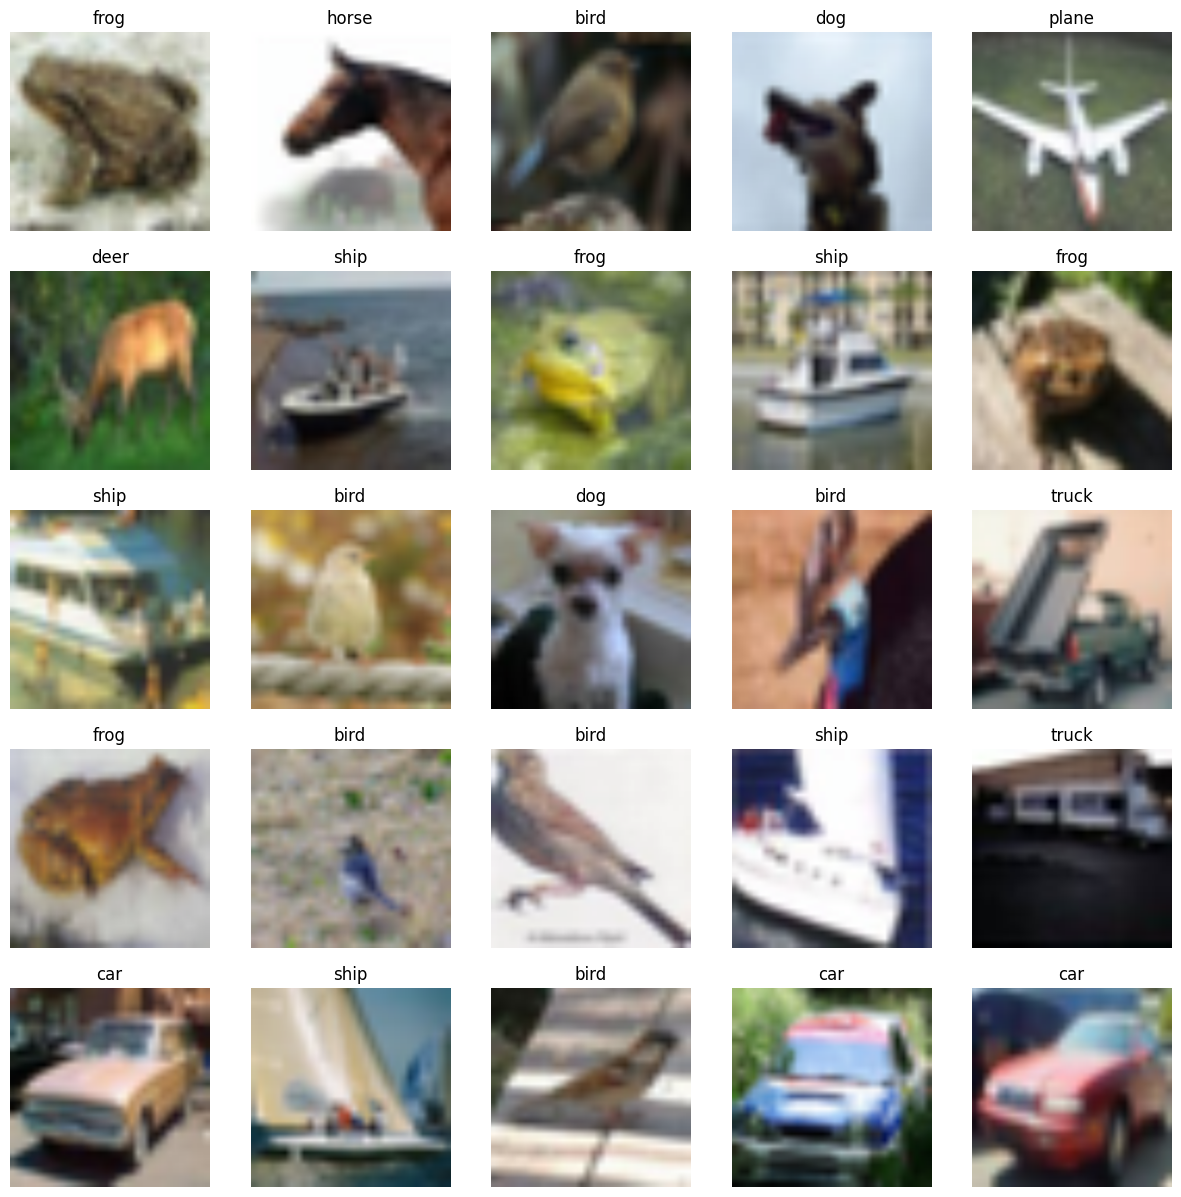

In [20]:
def imshow(img):
    # Unnormalize image
    img = img * std_trn[:, None, None] + mean_trn[:, None, None]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Get some training images
dataiter = iter(tr_full_loader)
images, labels = next(dataiter)

# Show images and labels in a grid 5x5
fig = plt.figure(figsize=(15, 15))
rows, cols = 5, 5
for i in range(0, rows * cols):
    img, label = images[i], labels[i]
    fig.add_subplot(rows, cols, i + 1)
    imshow(img)
    plt.title(classes[label])
    plt.axis(False)

In [21]:
print(f"Amount of batches processed in each epoch: {tr_full_set_len / batch_size}")

Amount of batches processed in each epoch: 50.0


# Non Proxy Labelling case

### Neural network setup

In [7]:
# Set up untrained AlexNet neural network with modified
# classification head to 10 classes, send this NN to GPU
alexnet_non_pl = models.alexnet(num_classes=10).to(device)

# Set up loss criterion
criterion = nn.CrossEntropyLoss()
# Set up and send to GPU accuracy metric
accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(classes)).to(device)
# Set up stohastic gradient descent method of NN training with
# learning rate = 0.001
# momentum = 0.9
# (original values from scientific paper)
optimizer = optim.SGD(alexnet_non_pl.parameters(), lr=0.001, momentum=0.9)

### Network training

In [8]:
# Set the number of epochs
epochs = 3
# Set the number of batches, after which info will be displayed
cycle = 25

# Create required arrays to store loss and accuracy
train_data_len = len(tr_full_loader)
train_loss_arr = np.zeros(epochs)
test_data_len = len(tst_set_loader)
test_loss_arr = np.zeros(epochs)
test_accuracy_arr = np.zeros(epochs)

# Create training and testing loop
for epoch in range(epochs):
    print(f"Current epoch: {epoch + 1}\n-------")
    
    ##### Training #####
    train_loss = test_acc = test_loss = 0
    # Set network to train mode
    alexnet_non_pl.train()
    
    # Add a loop through training batches
    for batch_num, (tr_inputs, tr_labels) in enumerate(tr_full_loader):
        # Send data to cuda (preferably)
        tr_inputs = tr_inputs.to(device)
        tr_labels = tr_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward pass + optimization
        outputs = alexnet_non_pl(tr_inputs).to(device)
        loss = criterion(outputs, tr_labels)
        loss.backward()
        optimizer.step()

        # Accumulatively add up the loss per epoch 
        train_loss += loss

        # Print out how many samples have been seen
        # Save loss each cycle batches (cycle*batch samples)
        if batch_num % cycle == 0 and batch_num != 0:
            print(f"Looked at {batch_num * batch_size} samples")
            print(f"Current train loss for batch: {loss}")
    ##### Training end #####
    
    ##### Testing #####
    # Set network to evaluation mode
    alexnet_non_pl.eval()
    # Turn on inference mode (no autograd)
    with torch.inference_mode():
        for tst_inputs, tst_labels in tst_set_loader:
            # Send data to cuda (preferably)
            tst_inputs = tst_inputs.to(device)
            tst_labels = tst_labels.to(device)
            predictions = alexnet_non_pl(tst_inputs).to(device)
            
            # Test loss and accuracy calculation
            test_loss += criterion(predictions, tst_labels)
            test_acc += accuracy(predictions.argmax(dim=1), tst_labels)
    ##### Testing end #####
    
        # Save average (throughout the epoch) loss and accuracy
        train_loss_arr[epoch] = train_loss / train_data_len
        test_loss_arr[epoch] = test_loss / test_data_len
        test_accuracy_arr[epoch] = test_acc / test_data_len
    
    # Print out average loss and accuracy of this epoch
    print(f"\nAverage train loss: {train_loss_arr[epoch]:.5f}")
    print(f"Average test loss: {test_loss_arr[epoch]:.5f}, Average test acc: {test_accuracy_arr[epoch]:.2f}%\n")

Current epoch: 1
-------
Looked at 12800 samples
Current train loss for batch: 2.2986178398132324
Looked at 25600 samples
Current train loss for batch: 2.3025524616241455
Looked at 38400 samples
Current train loss for batch: 2.214437961578369

Average train loss: 2.24261
Average test loss: 1.97583, Average test acc: 0.29%

Current epoch: 2
-------
Looked at 12800 samples
Current train loss for batch: 1.8430495262145996
Looked at 25600 samples
Current train loss for batch: 1.8827046155929565
Looked at 38400 samples
Current train loss for batch: 1.7750179767608643

Average train loss: 1.71503
Average test loss: 1.52774, Average test acc: 0.43%

Current epoch: 3
-------
Looked at 12800 samples
Current train loss for batch: 1.2983227968215942
Looked at 25600 samples
Current train loss for batch: 1.4208163022994995
Looked at 38400 samples
Current train loss for batch: 1.4184082746505737

Average train loss: 1.44337
Average test loss: 1.31813, Average test acc: 0.52%

Current epoch: 4
------

### Weights saving

In [9]:
# Save weights to file 'AlexNet_nonPL_CIFAR10_weights.pth''
torch.save(alexnet_non_pl.state_dict(), 'AlexNet_nonPL_CIFAR10_weights.pth')
# To load weigths:
# alexnet_non_pl.load_state_dict(torch.load('AlexNet_nonPL_CIFAR10_weights.pth''))
# alexnet_non_pl.eval()

### Accuracy and loss plots

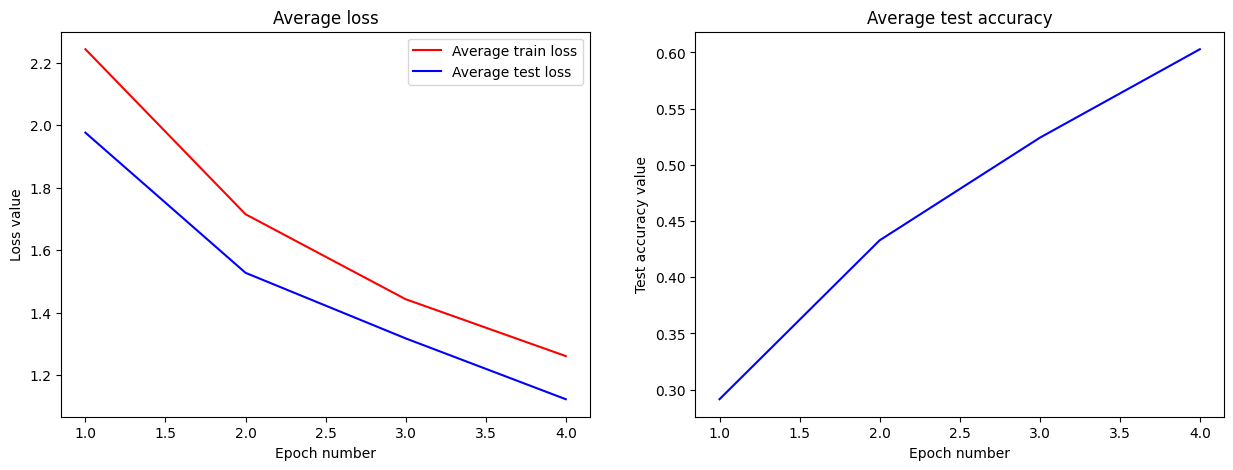

In [12]:
plt.figure(figsize = (15, 5))
epoch_arr = np.arange(1, epochs + 1)
plt.subplot(121)
plt.plot(epoch_arr, train_loss_arr, 'r', label='Average train loss')
plt.plot(epoch_arr, test_loss_arr,'b', label='Average test loss')
plt.title("Average loss")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.subplot(122)
plt.plot(epoch_arr, test_accuracy_arr, 'b')
plt.title("Average test accuracy")
plt.xlabel("Epoch number")
plt.ylabel("Test accuracy value")
plt.show()

# Proxy Labelling case

### Neural network setup

In [ ]:
# Set up untrained AlexNet neural network with modified
# classification head to 10 classes, send this NN to GPU
alexnet_pl = models.alexnet(num_classes=10).to(device)

# Set up stohastic gradient descent method of NN training with
# learning rate = 0.001
# momentum = 0.9
# (original values from scientific paper)
optimizer = optim.SGD(alexnet_pl.parameters(), lr=0.001, momentum=0.9)

### Network training

In [ ]:
# Set the number of epochs
epochs = 3

# Create training and testing loop
for epoch in range(epochs):
    print(f"Current epoch: {epoch + 1}\n-------")
    
    ##### Training #####
    train_loss = test_acc = test_loss = 0
    # Set network to train mode
    alexnet_pl.train()
    
    # Add a loop through training batches
    for batch_num, (tr_inputs, tr_labels) in enumerate(tr_part_lbl_loader):
        # Send data to cuda (preferably)
        tr_inputs = tr_inputs.to(device)
        tr_labels = tr_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward pass + optimization
        outputs = alexnet_pl(tr_inputs).to(device)
        loss = criterion(outputs, tr_labels)
        loss.backward()
        optimizer.step()

        # Accumulatively add up the loss per epoch 
        train_loss += loss

        # Print out how many samples have been seen
        # Save loss each cycle batches (cycle*batch samples)
        if batch_num % cycle == 0 and batch_num != 0:
            print(f"Looked at {batch_num * batch_size} samples")
            print(f"Current train loss for batch: {loss}")
    ##### Training end #####
    
    ##### Testing #####
    # Set network to evaluation mode
    alexnet_pl.eval()
    # Turn on inference mode (no autograd)
    with torch.inference_mode():
        for tst_inputs, tst_labels in tst_set_loader:
            # Send data to cuda (preferably)
            tst_inputs = tst_inputs.to(device)
            tst_labels = tst_labels.to(device)
            predictions = alexnet_pl(tst_inputs).to(device)
            
            # Test loss and accuracy calculation
            test_loss += criterion(predictions, tst_labels)
            test_acc += accuracy(predictions.argmax(dim=1), tst_labels)
    ##### Testing end #####
    
        # Save average (throughout the epoch) loss and accuracy
        train_loss_arr = train_loss / train_data_len
        test_loss_arr = test_loss / test_data_len
        test_accuracy_arr = test_acc / test_data_len
    
    # Print out average loss and accuracy of this epoch
    print(f"\nAverage train loss: {train_loss_arr:.5f}")
    print(f"Average test loss: {test_loss_arr:.5f}, Average test acc: {test_accuracy_arr:.2f}%\n")

Current epoch: 1
-------
Looked at 12800 samples
Current train loss for batch: 2.2986178398132324
Looked at 25600 samples
Current train loss for batch: 2.3025524616241455
Looked at 38400 samples
Current train loss for batch: 2.214437961578369

Average train loss: 2.24261
Average test loss: 1.97583, Average test acc: 0.29%

Current epoch: 2
-------
Looked at 12800 samples
Current train loss for batch: 1.8430495262145996
Looked at 25600 samples
Current train loss for batch: 1.8827046155929565
Looked at 38400 samples
Current train loss for batch: 1.7750179767608643

Average train loss: 1.71503
Average test loss: 1.52774, Average test acc: 0.43%

Current epoch: 3
-------
Looked at 12800 samples
Current train loss for batch: 1.2983227968215942
Looked at 25600 samples
Current train loss for batch: 1.4208163022994995
Looked at 38400 samples
Current train loss for batch: 1.4184082746505737

Average train loss: 1.44337
Average test loss: 1.31813, Average test acc: 0.52%

Current epoch: 4
------

In [ ]:
images = torch.tensor([sample[0] for sample in tr_part_non_lbl_set])
predictions = alexnet_pl(images)
# Horizontally concatenate images and labels
pred_train_set = torch.hstack((images, predictions))  # Concatenate along rows (vertically)
concat_train_set = torch.vstack((tr_full_set, pred_train_set))

tr_concat_set_loader = torch.utils.data.DataLoader(
    concat_train_set, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)

alexnet_pl = models.alexnet(num_classes=10).to(device)
optimizer = optim.SGD(alexnet_pl.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Set the number of epochs
epochs = 3
# Set the number of batches, after which info will be displayed
cycle = 25

# Create required arrays to store loss and accuracy
train_data_len = len(tr_concat_set_loader)
train_loss_arr = np.zeros(epochs)
test_data_len = len(tst_set_loader)
test_loss_arr = np.zeros(epochs)
test_accuracy_arr = np.zeros(epochs)

# Create training and testing loop
for epoch in range(epochs):
    print(f"Current epoch: {epoch + 1}\n-------")
    
    ##### Training #####
    train_loss = test_acc = test_loss = 0
    # Set network to train mode
    alexnet_pl.train()
    
    # Add a loop through training batches
    for batch_num, (tr_inputs, tr_labels) in enumerate(tr_concat_set_loader):
        # Send data to cuda (preferably)
        tr_inputs = tr_inputs.to(device)
        tr_labels = tr_labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward pass + optimization
        outputs = alexnet_pl(tr_inputs).to(device)
        loss = criterion(outputs, tr_labels)
        loss.backward()
        optimizer.step()

        # Accumulatively add up the loss per epoch 
        train_loss += loss

        # Print out how many samples have been seen
        # Save loss each cycle batches (cycle*batch samples)
        if batch_num % cycle == 0 and batch_num != 0:
            print(f"Looked at {batch_num * batch_size} samples")
            print(f"Current train loss for batch: {loss}")
    ##### Training end #####
    
    ##### Testing #####
    # Set network to evaluation mode
    alexnet_pl.eval()
    # Turn on inference mode (no autograd)
    with torch.inference_mode():
        for tst_inputs, tst_labels in tst_set_loader:
            # Send data to cuda (preferably)
            tst_inputs = tst_inputs.to(device)
            tst_labels = tst_labels.to(device)
            predictions = alexnet_pl(tst_inputs).to(device)
            
            # Test loss and accuracy calculation
            test_loss += criterion(predictions, tst_labels)
            test_acc += accuracy(predictions.argmax(dim=1), tst_labels)
    ##### Testing end #####
    
        # Save average (throughout the epoch) loss and accuracy
        train_loss_arr[epoch] = train_loss / train_data_len
        test_loss_arr[epoch] = test_loss / test_data_len
        test_accuracy_arr[epoch] = test_acc / test_data_len
    
    # Print out average loss and accuracy of this epoch
    print(f"\nAverage train loss: {train_loss_arr[epoch]:.5f}")
    print(f"Average test loss: {test_loss_arr[epoch]:.5f}, Average test acc: {test_accuracy_arr[epoch]:.2f}%\n")

Current epoch: 1
-------
Looked at 12800 samples
Current train loss for batch: 2.2986178398132324
Looked at 25600 samples
Current train loss for batch: 2.3025524616241455
Looked at 38400 samples
Current train loss for batch: 2.214437961578369

Average train loss: 2.24261
Average test loss: 1.97583, Average test acc: 0.29%

Current epoch: 2
-------
Looked at 12800 samples
Current train loss for batch: 1.8430495262145996
Looked at 25600 samples
Current train loss for batch: 1.8827046155929565
Looked at 38400 samples
Current train loss for batch: 1.7750179767608643

Average train loss: 1.71503
Average test loss: 1.52774, Average test acc: 0.43%

Current epoch: 3
-------
Looked at 12800 samples
Current train loss for batch: 1.2983227968215942
Looked at 25600 samples
Current train loss for batch: 1.4208163022994995
Looked at 38400 samples
Current train loss for batch: 1.4184082746505737

Average train loss: 1.44337
Average test loss: 1.31813, Average test acc: 0.52%

Current epoch: 4
------

### Weights saving

In [ ]:
# Save weights to file 'AlexNet_PL_CIFAR10_weights.pth''
torch.save(alexnet_pl.state_dict(), 'AlexNet_PL_CIFAR10_weights.pth')
# To load weigths:
# alexnet_pl.load_state_dict(torch.load('AlexNet_PL_CIFAR10_weights.pth''))
# alexnet_pl.eval()

### Accuracy and loss plots

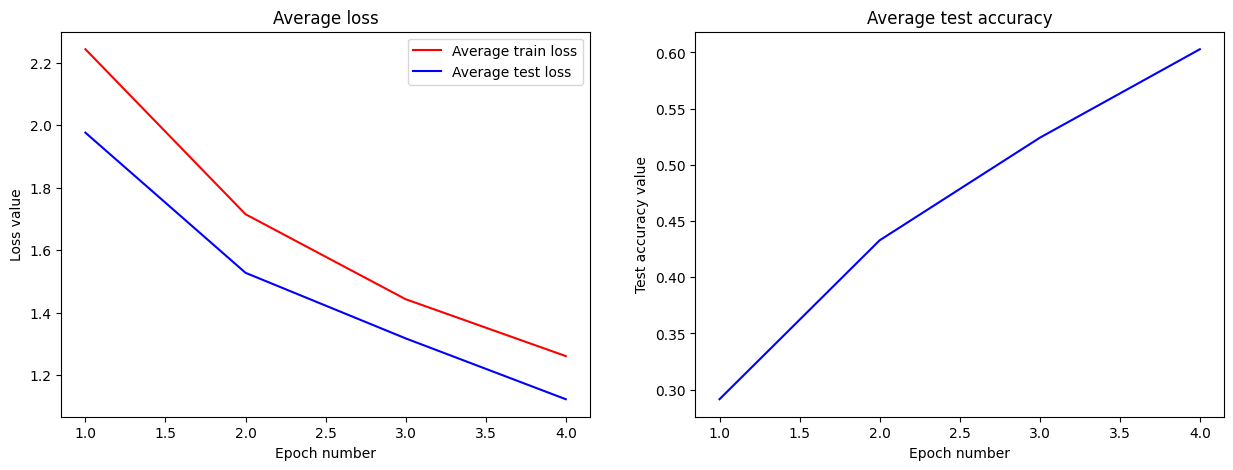

In [ ]:
plt.figure(figsize = (15, 5))
epoch_arr = np.arange(1, epochs + 1)
plt.subplot(121)
plt.plot(epoch_arr, train_loss_arr, 'r', label='Average train loss')
plt.plot(epoch_arr, test_loss_arr,'b', label='Average test loss')
plt.title("Average loss")
plt.legend()
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.subplot(122)
plt.plot(epoch_arr, test_accuracy_arr, 'b')
plt.title("Average test accuracy")
plt.xlabel("Epoch number")
plt.ylabel("Test accuracy value")
plt.show()

## Conclusions 
### As we see train and test loss were declining throughout the 4 epochs (as well as accuracy), this means that we stil haven't reached the optimum point (point, where train loss continue to decline, but test loss starts to rise). As a result it is advisable to continue training of the model, although, in this lab work, we will stop, due to limited computational resources. In the final run we got accuracy 59%, which is much better then accuracy of random classifier - 10%. In real situation we would also use validation test instead of test set, to fine tune hyperparameters of the model, and the test set would only be used to evaluate model after the training.